# Logistic Regression using TensorFlow


This is a summary of the trainning and testing of a logistic regression (or softmax) model using TensorFlow. 

This task is intended to classify properly the German Traffic Signs from The German Traffic Sign Detection Benchmark 
(http://benchmark.ini.rub.de/?section=gtsdb&subsection=dataset) which has 43 output classes

The main difference between the softmax and the log regression that I used for the model1 is that this computes 
to probability to belong to each class and logistic regression conventional uses an oVR approach which is composed of lots of binary classifiers

First I need to set the wd as the parent directory of this folder to import all the libraries and functions

In [9]:
import os 
__file__=os.getcwd()

In [2]:
os.getcwd()

'C:\\Users\\LinaMaria\\Desktop\\JUAN MANUEL\\Machine learning\\German Traffic Signs Detector\\German-Traffic-Signs-Detector\\reports'

In [3]:
from os.path import dirname, abspath
d = dirname(abspath(__file__))
os.chdir(d)


In [10]:
os.getcwd()

'C:\\Users\\LinaMaria\\Desktop\\JUAN MANUEL\\Machine learning\\German Traffic Signs Detector\\German-Traffic-Signs-Detector'

Now I can import all my functions

In [11]:
import os
import tensorflow as tf
import numpy as np
from PIL import Image
from sklearn.utils import shuffle
#from download import downloadDATA
import matplotlib.pyplot as plt
#from LeNet5 import getImagesAndLabels
import GetImages

Then I use a function to open the images from the folders imported from GetImages. See the function below

In [12]:
def getFlattenImagesAndLabels(DirectoryToSearch, TypeOfImage=1):
    """
   #################
   ### INPUTS ----------------1. DirectoryToSearch : A FOLDER IN ANY FOLDER OR SUBFOLDER OF THE
                              2. TypeOfImage 0 ----for test 1--- for train 2 for infer
   CURRENT WORKING DIRECTORY WHERE THERE ARE IMAGES.PPM
   
   #### OUTPUTS
   1 xImages:----------->numpy array size(nImages,32,32,1) 1 channel because images are grayscale
   2 Y_labels-----------> list with int class labels of len nImages
   ####A
   """
    new_wd=os.getcwd();
    os.chdir(new_wd)
    ## looking for DirectoryToSearch in path
    if os.path.exists(DirectoryToSearch) :
        files_Taken=os.listdir(DirectoryToSearch)
        files_Taken = [file for file in files_Taken if file.endswith("ppm")]
        trainFolder=DirectoryToSearch
    elif os.path.exists(os.getcwd()+DirectoryToSearch):
        trainFolder=os.getcwd()+DirectoryToSearch
        files_Taken =os.listdir(trainFolder)
        files_Taken = [file for file in files_Taken if file.endswith("ppm")]
    else:
        if(TypeOfImage==1):
            DirectoryToSearch='/images/train'
            print('\n INVALID DIRECTORY:\n taking files from images/train folder to avoid errors in training type "python app.py train --help" to avoid this error again\n\n\n')
        elif(TypeOfImage==0):
            DirectoryToSearch='/images/test'
            print('\n INVALID DIRECTORY:\n taking files from images/test folder to avoid errors in testing type "python app.py test --help" to avoid this error again\n\n\n')
        elif(TypeOfImage==2):
            DirectoryToSearch='/images/user'
            print('\n INVALID DIRECTORY:\n taking files from images/user folder to avoid errors in infering type "python app.py test --help" to avoid this error again\n\n\n')
            
        trainFolder=os.getcwd()+DirectoryToSearch
        files_Taken =os.listdir(trainFolder)
        files_Taken = [file for file in files_Taken if file.endswith("ppm")]
     ### creating a tensor for the Images and the labels in the model
    if len(files_Taken)==0:
        print('there arent any images to train the model')
    Y_labels=list()
    numbImages=len(files_Taken)
    ### creating a matrix
    xImages=np.zeros(shape=(numbImages,32*32))
    count=0
    ### RESIZING THE IMAGES TO 32.32 AND APPLYING GRAYSCALE FILTER
    for filename in files_Taken:
        im = Image.open(trainFolder+'/'+filename)
        final=preprocessImage(im)
        xImages[count]=final
        if(TypeOfImage==2):
            Y_labels.append(filename)
        else:
            Y_labels.append(int(filename[:2]))
        count+=1
    if(TypeOfImage==2):
        return xImages,Y_labels,trainFolder
    return xImages,Y_labels

When I get the images from the folders I include some preprocessing see in the preprocessing function, defined in GetImages, it includes grayscale, HistEquialization.

In [13]:
def preprocessImage(im):
    """
    a function that converts an rgb image to a flattlen vector.
    Grayscale, reshape to 32*32, HisEqualization and uses np.flattlen()
    INPUTS 
    1.im --------> A Rgb image of any size
    
    OUTPUTS
    1.A GRAYSCALE FLATTLEN VECTOR SHAPE(32**2)
    
    """
    im = im.convert("L")
    im=np.array(im)
    preprocesedImage=cv2.resize(im,(32,32))
    preprocesedImage = cv2.equalizeHist(preprocesedImage)
    preprocesedImage=preprocesedImage.flatten()
#        preprocesedImage=np.divide(final, 255)
    return preprocesedImage
      

In [14]:
os.getcwd()

'C:\\Users\\LinaMaria\\Desktop\\JUAN MANUEL\\Machine learning\\German Traffic Signs Detector\\German-Traffic-Signs-Detector'

Here I create the graph which has 2 placeholders one for the flaten images and one for the labels.

After that I need to create the weights of dimensions # features,nclasses and and the baises with shape 1,nclasses and the logits node perfoms an operation of matrix multiplication and adition of the biases.

To compare the trainlabels and the predictedLabels it uses the entropy model that Measures the probability error in discrete classification tasks in which the classes are mutually exclusive

It's remarkable to say that the train labels must be previously transformed to a binary sparse matrix with the one hot encoder operation of TF

The gradient descent method is chosen to perform the minimization and the correct_prediction and accuracy_operation tensors only say if the model fits well the data 

In [19]:
    BATCH_SIZE=64
    EPOCHS=50
    learning_rate=0.01
    n_out=43
    TrainImagesDirectory='images/train'
    xImages,Y_labels=GetImages.getFlattenImagesAndLabels(DirectoryToSearch=TrainImagesDirectory, TypeOfImage=1)
    print('training TF LogReg with '+str(len(Y_labels))+' input files')
    g = tf.Graph()
    with g.as_default():
        xTensor = tf.placeholder(tf.float32, (None, 32*32),name='X')
        yTensor = tf.placeholder(tf.int32, (None),name="Y")
        weight = tf.Variable(tf.truncated_normal(shape=[32*32, n_out], stddev=0.01), name="weights")
        bias = tf.Variable(tf.zeros([1, n_out]), name="bias")
        logits = tf.add(tf.matmul(xTensor, weight),bias,name='logits')
        one_hot_y = tf.one_hot(yTensor, n_out)
        entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=one_hot_y)
        loss = tf.reduce_mean(entropy) # computes the mean over samples in the batch
        optimizer =tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(loss)
        init = tf.global_variables_initializer()
        correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1),name='correct')
        accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32),name='accuracyOp')
        saver = tf.train.Saver()
        

training TF LogReg with 970 input files


# A function to evaluate the accuracy of the training is created 

It gives the accuracy of the model with respect to all the class labels given

In [20]:

def evaluate(xTensor,yTensor,accuracy_operation,X_data, y_data, BATCH_SIZE=64):
    """A FUNCTION TO EVALUATE THE ACCURACY OF THE LOGREG IN THE DATA
    INPUTS 
    1. x tfplace holder size(?,32*32)
    2. y tfplace holder size(?)
    3.accuracy_operation ---->the operation in the Logreg to determine if a LOGREG fails 
    4.X_data np.array(Nimages,32*32)
    5 y_data list of len (Nimages) 
    6.BATCH_SIZE size of the batch to evaluate the accuracy
    
    OUTPUT 
    1 total_accuracy / num_examples IT IT THE ACCURACY OF THE LOGREG
    OUTPUT
    """
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    #    print(X_data.shape)
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy=sess.run(accuracy_operation, feed_dict={xTensor: batch_x, yTensor: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

Now let's use the graph defined previously to run a session, in this sesion we will use the optimizer to get the weights and 
the biases that minimize the cost function

We will also use the evaluate function to get the accuracy of the model with respect to the trainning data, using the node accuracy op

At the end of the trainning epochs we use the save operation to save the model to do inferences and validation in another data

In [24]:
pathToSave=os.getcwd()+'/models/model2/saved/'
with tf.Session(graph=g) as sess:
    sess.run(init)
    num_samples = len(Y_labels)
    print("Training your Log Reg with Tensorflow ...\n")
    for i in range(EPOCHS):
        shuffled_images, y_train = shuffle(xImages, Y_labels)
        for offset in range(0, num_samples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = shuffled_images[offset:end], y_train[offset:end]
            sess.run(optimizer, feed_dict={xTensor: batch_x, yTensor: batch_y})
        validation_accuracy = evaluate(xTensor,yTensor,accuracy_operation,xImages, Y_labels)
#IN CASE VALIDATION ON TEST DATA         validation_accuracy2 = evaluate(X_test, ytest)
#            print("training RESULT AT EPOCH # {} : Validation Accuracy = {:.2f}%".format(i+1, (validation_accuracy*100)))
    print("\n\n FINAL RESULT AT EPOCH # {} : Validation Accuracy = {:.2f}%".format(i+1, (validation_accuracy*100)))
    saver.save(sess,pathToSave)

Training your Log Reg with Tensorflow ...



 FINAL RESULT AT EPOCH # 50 : Validation Accuracy = 100.00%


# Defining a function to evaluate the test accuracy

This function load the model save at ModelPath and run the accuracy operation in the testing data located at Directory_Test

In [28]:
def testLogReg(Directory_Test='/images/test' ,ModelPath='/models/model2/saved/'):
    """
    A function that loads the LOGREG model located in ModelPath 
    and uses it test the images in the Directory_Test
    INPUTS
    1.Directory_Test---> Directory to the images for testing
    2.ModelPath---------> the directory to load the tf graph
    OUTPUT.
    IT PRINTS THE ACCURACY OF THE LOG REG MODEL IN THE TESTING IMAGES
    
    
    """
    TypeOfImage=0
    X_test,Y_test=GetImages.getFlattenImagesAndLabels(Directory_Test,TypeOfImage)
    print('testing TF LogReg with '+str(len(Y_test))+' input files')
    with tf.Session() as sess:   
        loader = tf.train.import_meta_graph(os.getcwd()+ModelPath+'.meta')
        loader.restore(sess, tf.train.latest_checkpoint(os.getcwd()+ModelPath))
        graph = tf.get_default_graph()
        X=graph.get_tensor_by_name("X:0")
        Y=graph.get_tensor_by_name("Y:0")
        acOp=graph.get_tensor_by_name("accuracyOp:0")
        validation_accuracy=evaluate(X,Y,acOp,X_test, Y_test, BATCH_SIZE=64)
        print("\n\nTest Accuracy = {:.2f}%".format( (validation_accuracy*100)))
    return

In [29]:
testLogReg()

testing TF LogReg with 243 input files
INFO:tensorflow:Restoring parameters from C:\Users\LinaMaria\Desktop\JUAN MANUEL\Machine learning\German Traffic Signs Detector\German-Traffic-Signs-Detector/models/model2/saved/


Test Accuracy = 82.72%


It gives a good accuracy for this simple model 

Now let's run some inferences in the images located at the /images/user 
This operation takes the max probability from the logits node defined previously

In [32]:
def inferLogReg(Directory_infer='/images/user' ,ModelPath='/models/model2/saved/'):
    """
    A function that loads the LOGREG model located in ModelPath 
    and uses it test the images in the Directory_infer folder 
    INPUTS
    1.Directory_infer---> Directory to the images that will be classified
    2.ModelPath---------> the directory to load the tf graph
    OUTPUT.
    IT OPENS A PLT PLOT WINDOW WITH THE ORIGINAL IMAGE AND THE OUTPUT CLASS
    """
    TypeOfImage=2
    X_test,Y_test,inferFolder=GetImages.getFlattenImagesAndLabels(Directory_infer,TypeOfImage)
    print(X_test.shape)
    with tf.Session() as sess:   
        loader = tf.train.import_meta_graph(os.getcwd()+ModelPath+'.meta')
        loader.restore(sess, tf.train.latest_checkpoint(os.getcwd()+ModelPath))
        graph = tf.get_default_graph()
        X=graph.get_tensor_by_name("X:0")
        Logits=graph.get_tensor_by_name("logits:0")
        cont=0
        DictClasses=GetImages.getDictClasses()
        for i in X_test:
            i=i.reshape(1,32**2)
            Proba=sess.run(Logits, feed_dict={X: i})
            plt.figure(str(Y_test[cont]))
            im = Image.open(inferFolder+'/'+Y_test[cont])
            plt.text(-1,-1,'file'+Y_test[cont]+'   belongs to class'+DictClasses[int(np.argmax(Proba,1))])
            plt.imshow(im,vmin = 0, vmax = 255)
#            plt.imshow(i[0,:,:,0],cmap='gray', vmin = 0, vmax = 1)
#                plt.show()
            cont=cont+1
    plt.show()
    return

(8, 1024)
INFO:tensorflow:Restoring parameters from C:\Users\LinaMaria\Desktop\JUAN MANUEL\Machine learning\German Traffic Signs Detector\German-Traffic-Signs-Detector/models/model2/saved/


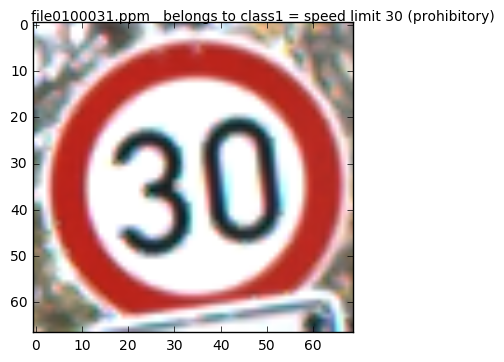

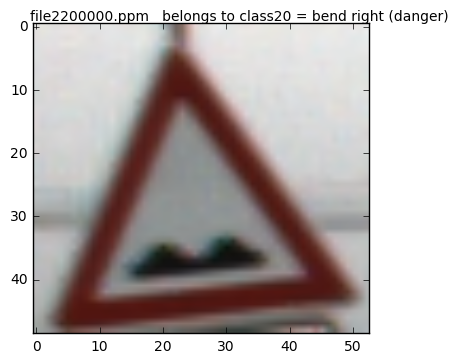

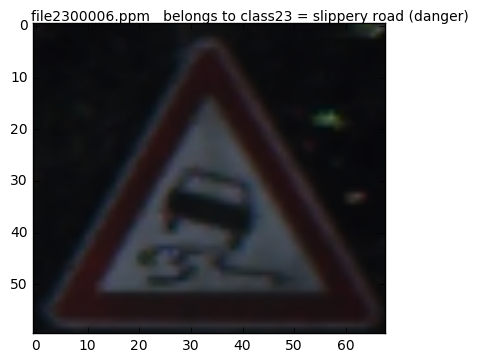

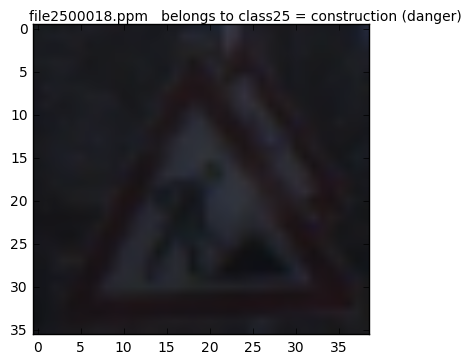

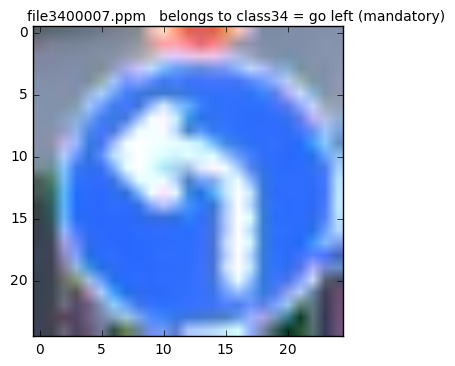

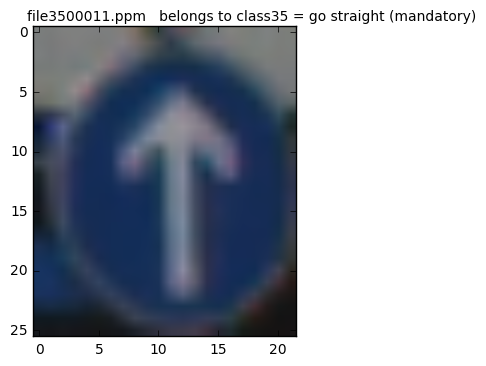

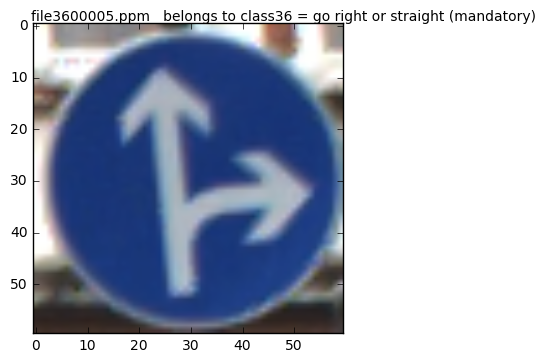

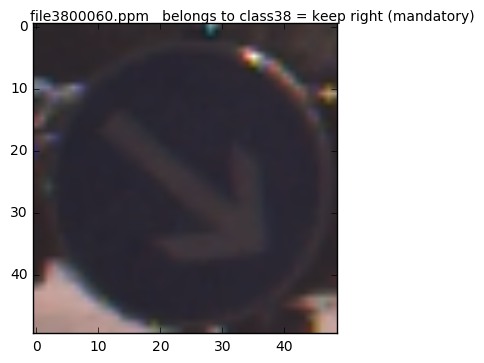

In [33]:
inferLogReg()

In the images above in the image name example "file2200000.ppm" the first two numbers in this case
'22' gives the real class of the validation data and the predicted label was '20'.
In the validation data the accuracy was 7/8
That's 87.5%

It would be a good idea trying to implement hyperparameter tuning to improve the accuracy of this model